<a href="https://colab.research.google.com/github/Ziyi-star/Bachelor-Project/blob/main/notebooks/handlebar/LSTM/Lstm__Handlebar_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For Vscode
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md
from sklearn.model_selection import train_test_split    #model selection and scaling data
from sklearn.preprocessing import StandardScaler
import tensorflow as tf #building model
RANDOM_SEED = 42

import sys
sys.path.append('../../../')   # Add parent directory to Python path
from utils.Plots import *

In [2]:
df = pd.read_csv('../../../data/handlebar/Accelerometer_data_combined_segmented_curb_height_overlap_50.csv')
df.head()

,curb_height,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,Acc-Z_8,Acc-Z_9,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0.0,8.762772,8.753204,8.762772,8.781937,8.753204,8.748413,8.738831,8.748413,8.743622,...,8.786728,8.801086,8.820236,8.786728,8.777145,8.772354,8.781937,8.801086,8.781937,8.753204
1,0.0,8.762772,8.762772,8.748413,8.767563,8.729263,8.695740,8.724472,8.767563,8.767563,...,8.753204,8.772354,8.786728,8.781937,8.786728,8.777145,8.738831,8.820236,8.738831,8.757996
2,0.0,8.781937,8.796295,8.772354,8.772354,8.772354,8.786728,8.781937,8.801086,8.767563,...,8.777145,8.753204,8.767563,8.762772,8.762772,8.753204,8.748413,8.762772,8.772354,8.767563
3,0.0,8.781937,8.753204,8.801086,8.753204,8.829819,8.753204,8.786728,8.815445,8.762772,...,8.805878,8.796295,8.781937,8.801086,8.810669,8.796295,8.805878,8.791504,8.791504,8.772354
4,0.0,8.757996,8.762772,8.777145,8.767563,8.786728,8.777145,8.753204,8.757996,8.777145,...,8.757996,8.757996,8.772354,8.767563,8.757996,8.743622,8.777145,8.743622,8.786728,8.796295


In [3]:
#scaling data, because neural network works better with scaled data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df.iloc[:, 1:])

In [4]:
# Convert the scaled data back to DataFrames for further processing
train_data_scaled_df = pd.DataFrame(data_scaled, columns=df.iloc[:, 1:].columns)
# Add the curb_height column back
train_data_scaled_df['curb_height'] = df['curb_height']
train_data_scaled_df.shape

(3727, 101)

In [6]:
# Filter and slice the data
normal_train_data_scaled = train_data_scaled_df[train_data_scaled_df['curb_height'] == 0.0].iloc[:, :-1]
abnormal_train_data_scaled_one = train_data_scaled_df[train_data_scaled_df['curb_height'] == 1.0].iloc[:, :-1]
abnormal_train_data_scaled_two = train_data_scaled_df[train_data_scaled_df['curb_height'] == 2.0].iloc[:, :-1]
abnormal_train_data_scaled_three = train_data_scaled_df[train_data_scaled_df['curb_height'] == 3.0].iloc[:, :-1]
abnormal_train_data_scaled_four = train_data_scaled_df[train_data_scaled_df['curb_height'] == 4.0].iloc[:, :-1]

In [7]:
# Cast to float32
normal_train_data_scaled = normal_train_data_scaled.astype("float32")
abnormal_train_data_scaled_one = abnormal_train_data_scaled_one.astype("float32")
abnormal_train_data_scaled_two = abnormal_train_data_scaled_two.astype("float32")
abnormal_train_data_scaled_three = abnormal_train_data_scaled_three.astype("float32")
abnormal_train_data_scaled_four = abnormal_train_data_scaled_four.astype("float32")

In [8]:
# Reshape the data for LSTM input((samples, timesteps, features))
normal_train_data_scaled_lstm = np.expand_dims(normal_train_data_scaled, axis=1)
abnormal_train_data_scaled_one_lstm = np.expand_dims(abnormal_train_data_scaled_one, axis=1)
abnormal_train_data_scaled_two_lstm = np.expand_dims(abnormal_train_data_scaled_two, axis=1)
abnormal_train_data_scaled_three_lstm = np.expand_dims(abnormal_train_data_scaled_three, axis=1)
abnormal_train_data_scaled_four_lstm = np.expand_dims(abnormal_train_data_scaled_four, axis=1)


In [9]:
from keras import ops
load_model = tf.keras.models.load_model('../../../models/lstm_autoencoder_best.keras')

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


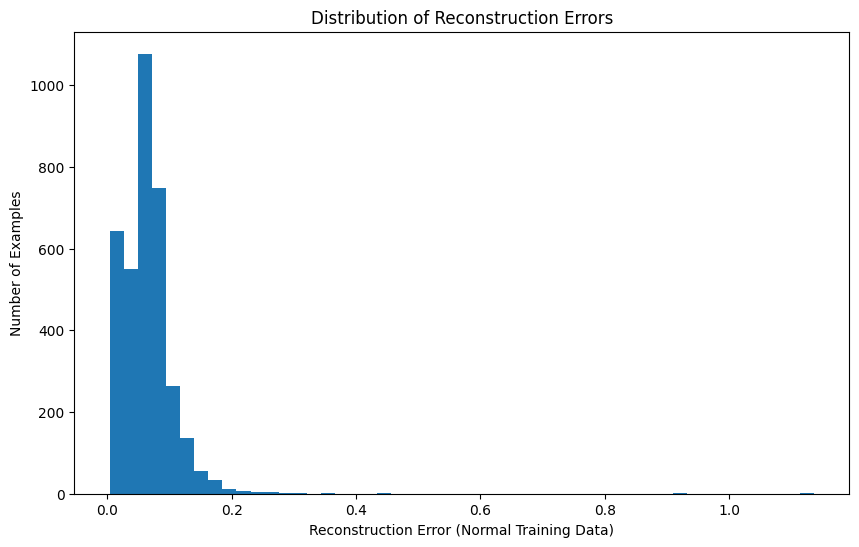

In [10]:
# Calculate reconstruction errors for train data
train_reconstructions_normal = load_model.predict(normal_train_data_scaled_lstm)
train_loss_normal = tf.keras.losses.mae(train_reconstructions_normal, normal_train_data_scaled_lstm)
# Flatten the loss array and convert to numpy for plotting
train_loss_normal_flat = train_loss_normal.numpy().flatten()
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal_flat, bins=50)
plt.xlabel("Reconstruction Error (Normal Training Data)")
plt.ylabel("Number of Examples")
plt.title("Distribution of Reconstruction Errors")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


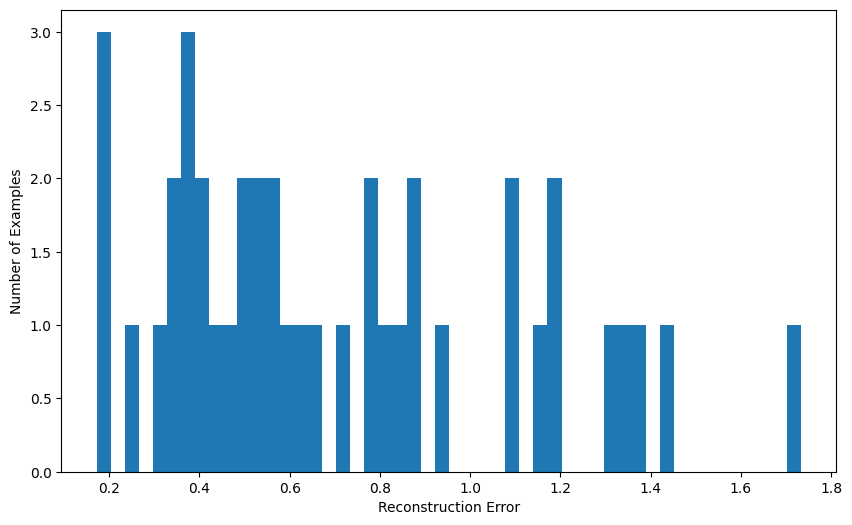


Minimum reconstruction error for abnormal data: 0.1719


In [11]:
# Calculate reconstruction errors for abnormal data
train_reconstructions_abnormal_one = load_model.predict(abnormal_train_data_scaled_one_lstm)
train_loss_abnormal_one = tf.keras.losses.mae(train_reconstructions_abnormal_one, abnormal_train_data_scaled_one_lstm)
# Flatten the loss array and convert to numpy for plotting
train_loss_abnormal_one_flat = train_loss_abnormal_one.numpy().flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal_one_flat, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Examples")
plt.show()

# Calculate and display minimum reconstruction error for abnormal data
min_error = np.min(train_loss_abnormal_one_flat)
print(f"\nMinimum reconstruction error for abnormal data: {min_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


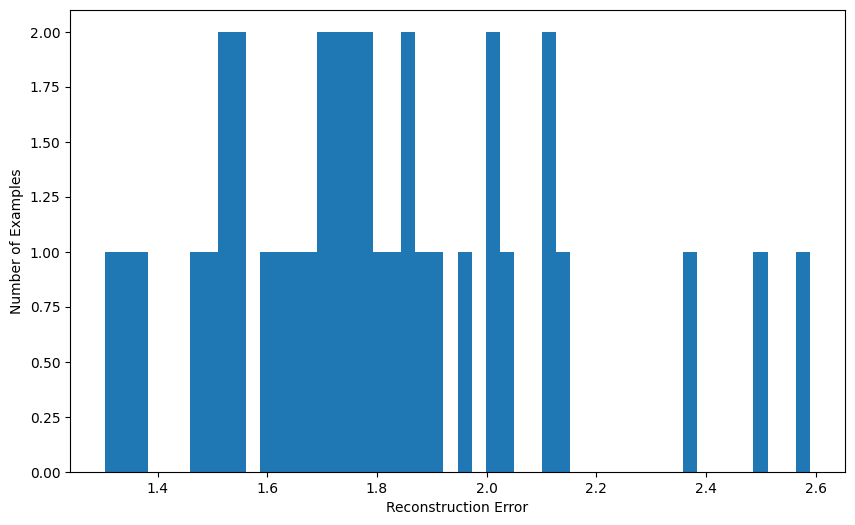


Minimum reconstruction error for abnormal data: 1.3045


In [15]:
# Calculate reconstruction errors for abnormal data
train_reconstructions_abnormal_two = load_model.predict(abnormal_train_data_scaled_two_lstm)
train_loss_abnormal_two = tf.keras.losses.mae(train_reconstructions_abnormal_two, abnormal_train_data_scaled_two_lstm)
# Flatten the loss array and convert to numpy for plotting
train_loss_abnormal_two_flat = train_loss_abnormal_two.numpy().flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal_two_flat, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Examples")
plt.show()

# Calculate and display minimum reconstruction error for abnormal data 2cm
min_error = np.min(train_loss_abnormal_two_flat)
print(f"\nMinimum reconstruction error for abnormal data: {min_error:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


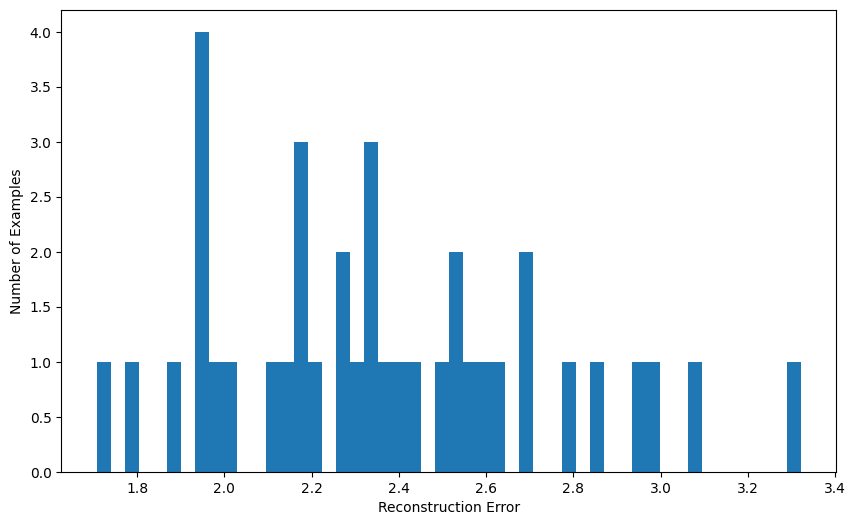


Minimum reconstruction error for abnormal data: 1.7068


In [16]:
# Calculate reconstruction errors for abnormal data
train_reconstructions_abnormal_three = load_model.predict(abnormal_train_data_scaled_three_lstm)
train_loss_abnormal_three = tf.keras.losses.mae(train_reconstructions_abnormal_three, abnormal_train_data_scaled_three_lstm)
# Flatten the loss array and convert to numpy for plotting
train_loss_abnormal_three_flat = train_loss_abnormal_three.numpy().flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal_three_flat, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Examples")
plt.show()

# Calculate and display minimum reconstruction error for abnormal data
min_error = np.min(train_loss_abnormal_three_flat)
print(f"\nMinimum reconstruction error for abnormal data: {min_error:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


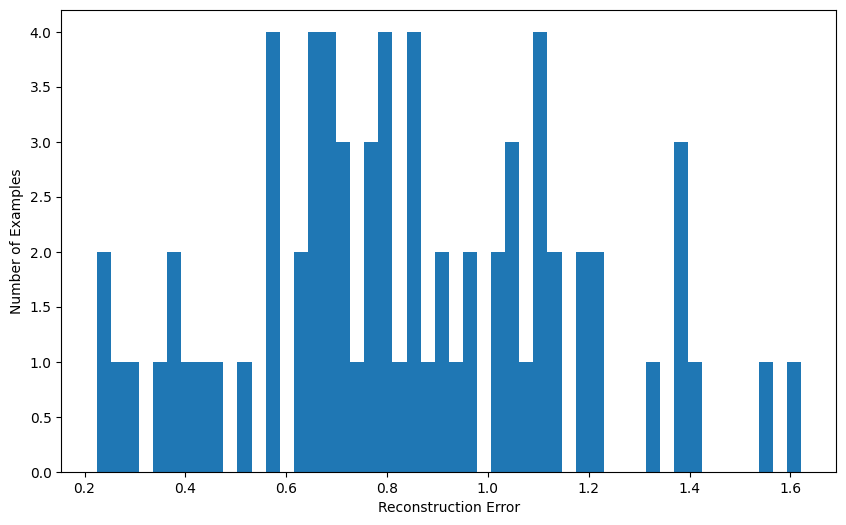


Minimum reconstruction error for abnormal data: 0.2237


In [17]:
# Calculate reconstruction errors for abnormal data
train_reconstructions_abnormal_four = load_model.predict(abnormal_train_data_scaled_four_lstm)
train_loss_abnormal_four = tf.keras.losses.mae(train_reconstructions_abnormal_four, abnormal_train_data_scaled_four_lstm)
# Flatten the loss array and convert to numpy for plotting
train_loss_abnormal_four_flat = train_loss_abnormal_four.numpy().flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(train_loss_abnormal_four_flat, bins=50)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Examples")
plt.show()

# Calculate and display minimum reconstruction error for abnormal data
min_error = np.min(train_loss_abnormal_four_flat)
print(f"\nMinimum reconstruction error for abnormal data: {min_error:.4f}")

Minimum reconstruction error for normal data: 0.0038
Minimum reconstruction error for 1cm data: 0.1719
Minimum reconstruction error for 2cm data: 1.3045
Minimum reconstruction error for 3cm data: 1.7068
Minimum reconstruction error for Ramp data: 0.2237


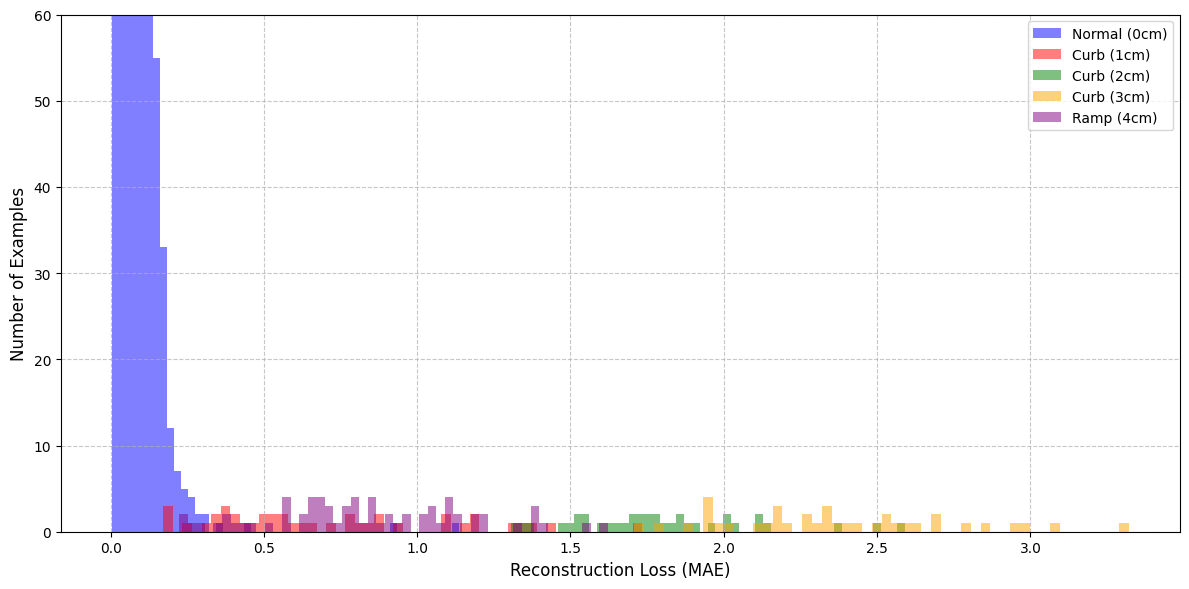

In [ ]:
# Create figure with specified size
plt.figure(figsize=(12, 6))

# Plot histograms for each type of data
plt.hist(train_loss_normal_flat, bins=50, alpha=0.5, label='Normal (0cm)', color='blue')
plt.hist(train_loss_abnormal_one_flat, bins=50, alpha=0.5, label='Curb (1cm)', color='red')
plt.hist(train_loss_abnormal_two_flat, bins=50, alpha=0.5, label='Curb (2cm)', color='green')
plt.hist(train_loss_abnormal_three_flat, bins=50, alpha=0.5, label='Curb (3cm)', color='orange')
plt.hist(train_loss_abnormal_four_flat, bins=50, alpha=0.5, label='Ramp (4cm)', color='purple')

# Customize the plot
plt.xlabel('Reconstruction Loss (MAE)', fontsize=12)
plt.ylabel('Number of Examples', fontsize=12)
plt.ylim(0, 60)
#plt.title('Distribution of Reconstruction Loss for Different Curb Heights', fontsize=14)
#plt.title('Distribution of Reconstruction Loss for Curb Heights 1cm & 2cm', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

# Make axis labels more readable
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()